In [2]:
%pip install tensorflow

In [3]:


import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as vgg16_preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import os


In [4]:
# Define the preprocessing function for VGG16
def preprocess_input(img):
    img = vgg16_preprocess_input(img)
    return img


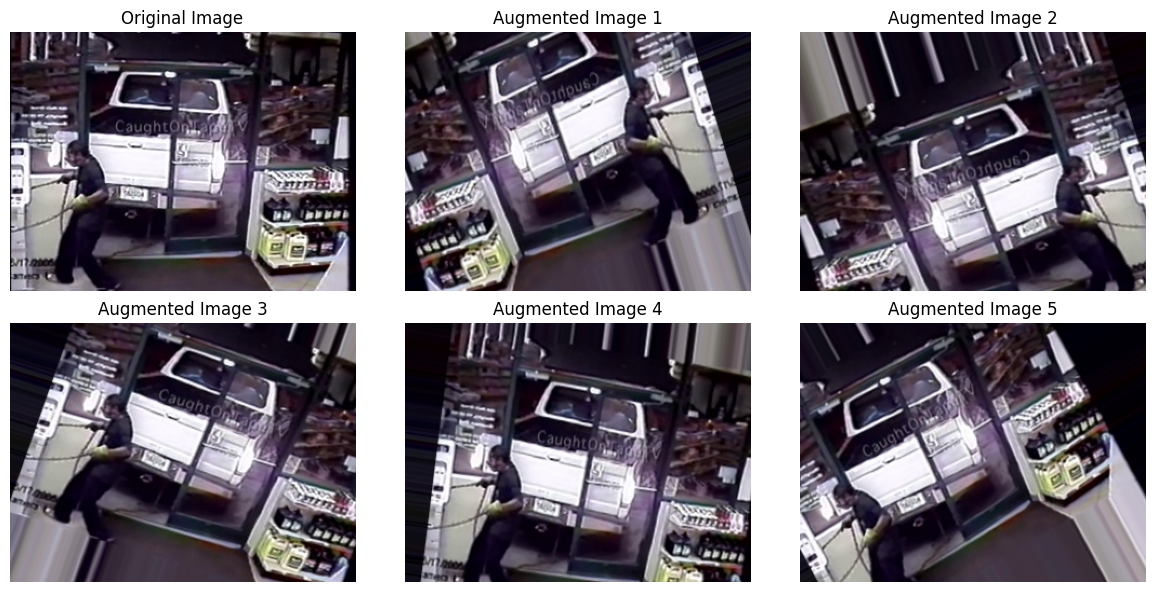

In [5]:
# Define the data generator with data augmentation
data_generator = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load an example image
image_path = r'C:\Users\swadh\OneDrive\Desktop\crimedetection\Frames_for_Crime\Burglary\Burglary007_x264_fr0.jpg'
image = load_img(image_path, target_size=(240, 320))
image_array = img_to_array(image)
image_array = np.expand_dims(image_array, axis=0)

plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
plt.imshow(image_array[0].astype(np.uint8))
plt.title('Original Image')
plt.axis('off')

aug_iter = data_generator.flow(image_array, batch_size=1)

# Display augmented images
for i in range(5):
    augmented_images = next(aug_iter)
    plt.subplot(2, 3, i + 2)
    plt.imshow(augmented_images[0].astype(np.uint8))
    plt.title(f'Augmented Image {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()



In [6]:
BATCH_SIZE_TRAINING = 32
IMAGE_RESIZE = (240, 320)

# Define the training data generator
train_data_generator = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest",
    preprocessing_function=preprocess_input
)

# Create the training data generator
train_generator = train_data_generator.flow_from_directory(
    r'C:\Users\swadh\OneDrive\Desktop\crimedetection',
    target_size=IMAGE_RESIZE,
    batch_size=BATCH_SIZE_TRAINING,
    class_mode='binary',
    classes=['Frames_for_Crime', 'Frames_for_Normal']
)


Found 2230 images belonging to 2 classes.


In [7]:
print(f'Found {train_generator.samples} images belonging to {train_generator.num_classes} classes.')
print(f'train_gen.class_indices: {train_generator.class_indices}')

# Define the VGG16 model
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(240, 320, 3)))
headModel = baseModel.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Flatten()(headModel)
headModel = Dense(1024, activation="relu")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

# Freeze the base model layers
for layer in baseModel.layers:
    layer.trainable = False

# Compile the model
adam = optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])


Found 2230 images belonging to 2 classes.
train_gen.class_indices: {'Frames_for_Crime': 0, 'Frames_for_Normal': 1}


In [8]:
# Early stopping callback
cb_early_stopper = EarlyStopping(monitor='loss', patience=4)


In [9]:
NUM_EPOCHS = 10
STEPS_PER_EPOCH_TRAINING = train_generator.samples // BATCH_SIZE_TRAINING

# Train the model
fit_history = model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
    epochs=NUM_EPOCHS,
    callbacks=[cb_early_stopper]
)


Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 368s 5s/step - accuracy: 0.7095 - loss: 0.6695
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 0s/step - accuracy: 0.8750 - loss: 0.2068  
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 369s 5s/step - accuracy: 0.9192 - loss: 0.2053
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 184us/step - accuracy: 0.9688 - loss: 0.1302
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 377s 5s/step - accuracy: 0.9363 - loss: 0.1624
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 132us/step - accuracy: 0.9375 - loss: 0.1029
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 387s 6s/step - accuracy: 0.9559 - loss: 0.1350
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 230us/step - accuracy: 0.9688 - loss: 0.1544
Epoch 9/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 374s 5s/step - accuracy: 0.9672 - loss: 0.0978
Epoch 10/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 0s/step - accuracy: 1.0000 - loss: 0.0261  


In [10]:
print(fit_history.history.keys())

dict_keys(['accuracy', 'loss'])


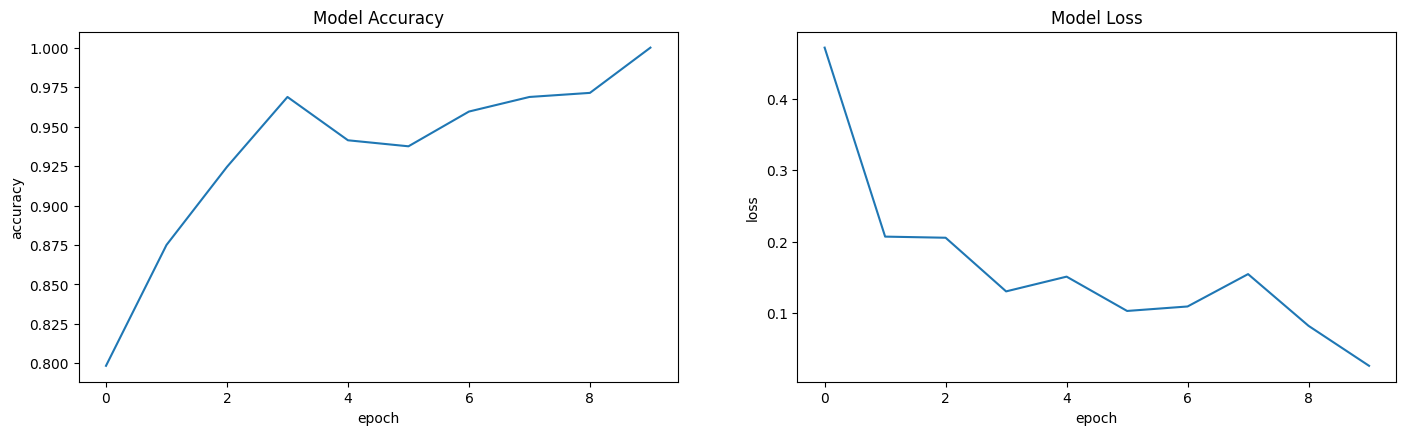

In [11]:

# Plot the training history
plt.figure(1, figsize=(17,10))

plt.subplot(221)
plt.plot(fit_history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.subplot(222)
plt.plot(fit_history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()


In [12]:
# Define the test data generator
test_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Create a generator for the test data
test_generator = test_data_generator.flow_from_directory(
    r'C:\Users\swadh\OneDrive\Desktop\crimedetection',
    target_size=IMAGE_RESIZE,
    batch_size=BATCH_SIZE_TRAINING,
    class_mode='binary',
    classes=['test_crime', 'test_normal']
)

# Evaluate the model on the test data
evaluation = model.evaluate(test_generator)
print(f"Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}")


Found 556 images belonging to 2 classes.
18/18 ━━━━━━━━━━━━━━━━━━━━ 93s 5s/step - accuracy: 0.9713 - loss: 0.0864
Test Loss: 0.08312322944402695, Test Accuracy: 0.9730215668678284


In [13]:
model.save('C:/Users/swadh/OneDrive/Desktop/crimedetection/vgg16.h5')